# Day 2, session 1: Interacting with Hi-C matrices

In this session, we will be using python to manipulate and extract information from Hi-C datasets.

## The cooler API

We will quickly go through the main features of the cooler API. This package allows to explore and interact with Hi-C data in an intuitive and memory-efficient way.

It is easy to write custom scripts in combination with cooler because data extracted from coolers is either returned as pandas.DataFrames or numpy.Arrays.

### Data structures

Most Hi-C storage format will comprise 3 tables: the matrix, the bins coordinates and chromosome sizes.
Since we are using the cool format, each dataset is a single file containing mukltiple tables.

We can access those tables using the cooler API as follows:


In [1]:
# Get information on chromosomes
import cooler
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

clr_g1 = cooler.Cooler('data/g1.cool')
chroms = clr_g1.chroms()[:]

chroms.head()

,name,length
0,Sc_chr01,230218
1,Sc_chr03,316620
2,Sc_chr06,270161
3,Sc_chr09,439888


In [2]:
bins = clr_g1.bins()[:]
bins.loc[bins.chrom == 'Sc_chr01', :]

,chrom,start,end,weight
0,Sc_chr01,0,2000,0.069221
1,Sc_chr01,2000,4000,0.094031
2,Sc_chr01,4000,6000,NaN
3,Sc_chr01,6000,8000,0.084108
4,Sc_chr01,8000,10000,0.067953
...,...,...,...,...
111,Sc_chr01,222000,224000,0.153755
112,Sc_chr01,224000,226000,NaN
113,Sc_chr01,226000,228000,NaN
114,Sc_chr01,228000,230000,0.285861


Cooler can load tables from the HDF5 architecture using the corresponding methods `bins()`, `chroms()` and `matrix()`. Each method returns a view on the HDF5 table. in order to be explicitely loaded into memory, these views need to be queried. For example, to load the whole table we call `[:]` on the view.

Once loaded, the `bins` and `chroms` tables are exposed as pandas DataFrame. This means we can query and process them using standard pandas methods.

Instead of loading the whole table from the view, we can use the `fetch` method and provide a UCSC format genomic region to load from the view.

<IPython.core.display.Javascript object>


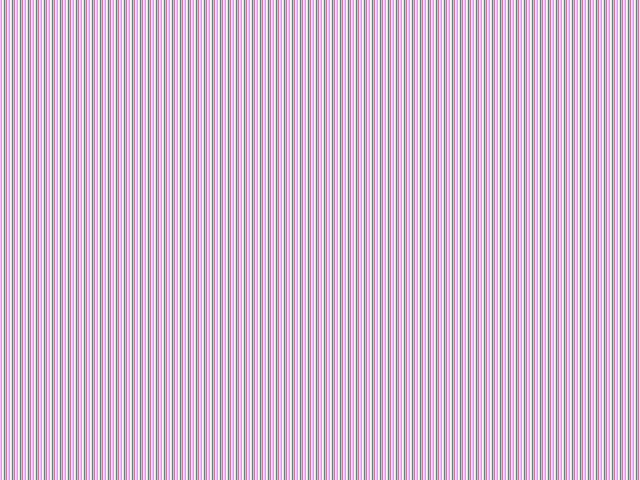

In [3]:
%matplotlib notebook
mat_g1 = clr_g1.matrix(balance=True).fetch('Sc_chr01:50000-150000')
plt.imshow(mat_g1, cmap='afmhot_r', vmax=np.percentile(mat_g1, 95))

By default, the matrix is returned in dense format as a numpy array. This means we can use all standard numpy methods on it. The issue with dense matrices is that their memory size scales with the square of the genome size.

Alternatively, we can specify `sparse=True` when calling the `matrix()` method. This will instead return a `scipy.sparse` matrix object. This is often necessary when working with large matrices. The main drawback of working with sparse matrices is that they can not be visualized directly.

### Metadata

All metadata accessible on the command line via `cooler info` can also be retrieved using the cooler API.
This metadata is stored as a dictionary in the info attribute. This includes relevant information such as the total coverage.

In [4]:
clr_g1.info

{'bin-size': 2000,
 'bin-type': 'fixed',
 'creation-date': '2020-12-30T19:43:07.300938',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/mirnylab/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.8.7',
 'genome-assembly': 'unknown',
 'metadata': {},
 'nbins': 631,
 'nchroms': 4,
 'nnz': 29699,
 'storage-mode': 'symmetric-upper',
 'sum': 560495}

## Contacts vs genomic distance

The main feature of all Hi-C matrices is the diagonal gradient due to the polymer behaviour of chromatin. This gradient reflects the decay of interaction frequencies with genomic distance.

We can visualize it using a curve of contact probability vs genomic distance. This is sometimes called "genomic distance law" or "distance decay" and abbreviated P(s).

> How would you compute the contacts according to genomic distance from the Hi-C matrix ?

> What happens towards the largest genomic distances ? Why and how could we fix this ?


In [ ]:
def distance_law(matrix, res=2000):
    xs = [x * res for x in range(matrix.shape[0])]
    ys = np.zeros(len(xs))
    ...
    return [xs, ys]
    
xs, ys = distance_law(clr_g1.matrix(balance=True).fetch('Sc_chr01'), res=clr_g1.binsize)

In [ ]:
%matplotlib notebook
plt.loglog(xs, ys)

Although the P(s) can readily be computed from Hi-C contact maps, the curve will be smoother if computed directly from the pairs file. This is because reads have already been discretized into "bins" by the time we generated the matrix. Below is the code to compute the P(s) from a pairs file:

In [18]:
# Get length of longest chromosome
longest = max(clr_g1.chroms()[:]['length'])
# Discretize distances into "distance bins" of exponentially increasing size
n_bins = int(np.log(longest)/np.log(1.1))
xs = np.unique(np.logspace(0, n_bins, num=n_bins+1, base=1.1, dtype=np.int))
ys = np.zeros(len(xs))
with open('data/valid.pairs', 'r') as pairs:
    for line in pairs:
        if line[0] == '#':
            continue
        else:
            line = line.split('\t')
            if line[1] == line[3]:  # same chromosome
                dist = abs(int(line[2]) - int(line[4])) # Compute intrachrom distance
                dist_bin = np.searchsorted(xs, dist, side='right') - 1
                ys[dist_bin] += 1

<IPython.core.display.Javascript object>


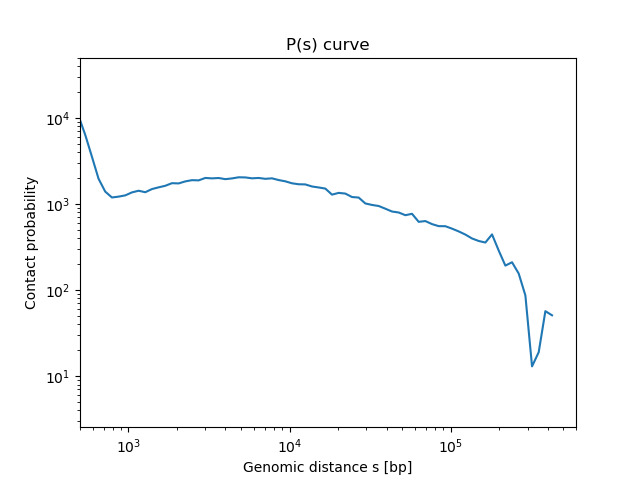

Text(0.5, 1.0, 'P(s) curve')

In [19]:
%matplotlib notebook
plt.loglog(xs, ys)
plt.xlim([500, 600000])
plt.xlabel("Genomic distance s [bp]")
plt.ylabel("Contact probability")
plt.title("P(s) curve")

> What happens if you modify the code to compute the P(s) separately for strand combinations (++, --, +-, -+) ?

There are existing and more polished packages that already compute P(s) curves. Here are a few of them:

* cooltools: [tutorial](https://cooltools.readthedocs.io/en/latest/notebooks/01_scaling-curves.html)
* [hicstuff](https://github.com/koszullab/hicstuff): From pairs via the command line (`hicstuff distancelaw`)
* [fanc](): From matrices via [`fanc.plotting.distance_decay_plot()`](https://fan-c.readthedocs.io/en/latest/api/modules/plotting.html?highlight=decay#fanc.plotting.distance_decay_plot).

## Observed / expected

Often, we are not interested in the diagonal gradient and want to rid the matrix of it. This is done by dividing each pixel by the average of its diagonal.
We often call the resulting values "observed / expected contacts".

In [ ]:
def obs_exp(obs_mat):
    exp_mat = np.zeros(obs_mat.shape)
    ...
    return obs_mat / exp_mat

## Aggregating from multiple regions

In this exercise, we will be comparing the local contacts of a set of regions with random background.

We have a BED file containing the binding sites of CTCF and want to investigate whether these sites are associated with a specific contact pattern.

> How would you proceed to aggregate Hi-C regions corresponding to the coordinates in the BED file ?

In [ ]:
# Boilerplate code to get regions
RADIUS = 50000
bed = pd.read_csv('data/ctcf.bed', sep='\t')
pileup = np.zeros((RADIUS*2, RADIUS*2))
for i, region in bed.iterrows():
    chrom = region[0]
    mid = (region[1] + region[2]) / 2
    region = f'{chrom}:{mid-RADIUS}-{mid+RADIUS}'
    ...

## Computing the 4C-like profile of a region

Sometimes we are curious about the contacts of a specific region (or a few regions) with the rest of the genome. This is the information that would be generated by a 4C experiment, but we can emulate it with Hi-C data.

> Can you think of a way to compute the 4C like profile of a region from the Hi-C matrix using standard numpy methods ?

> How does it change when using the observed / expected matrix instead ?

In [77]:
# Importing function to detrend matrix
from chromosight.utils.preprocessing import detrend

def prof_4c(mat, reg):
    prof = np.ones(mat.shape[0])
    ...
    return prof

mat = clr_g1.matrix(balance=True)[:]
prof = prof_4c(mat, clr_g1.extent('Sc_chr01:130000-170000'))

<IPython.core.display.Javascript object>


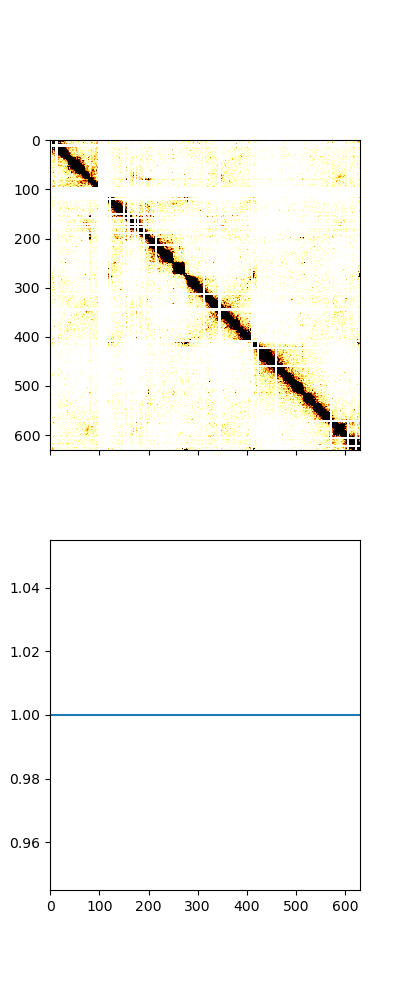

In [86]:
%matplotlib notebook
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(4, 10))
ax[0].imshow(mat, cmap='afmhot_r', vmax=0.01)
ax[1].plot(prof)

## Visualization

It is often more intuitive to show Hi-C matrices directly. However, when showing Hi-C matrices in figures, it is important that the data has been correctly preprocessed and that the different matrices are comparable.

In [ ]:
from cooltools.sample import sample_pixels_exact
count = min(mat1.sum(), mat2.sum())
mat1 = clr_g1.matrix(balance=False).fetch('Sc_chr01')
mat2 = clr_m.matrix(balance=False).fetch('Sc_chr01')
...
                        